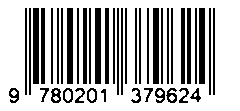

Data string: 0000000000000101011101100010010100111001001101001110011001010101000010100010011101001010000110110010111001010000000000000


In [2]:
# https://www.dynamsoft.com/codepool/locating-and-decoding-ean13-python-opencv.html
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Create a thresholded image.
img = cv2.imread("/content/barcode.png")
blur = cv2.blur(img,(3,3))
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
ret, thresh =cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

cv2_imshow(thresh)

# The value of the white pixels of the thresholded images is 255 and the black pixels 0. 
# We need to invert it and replace 255 with 1 to conform to the 0 and 1 pattern. 
# Only one line of the barcode is needed and here, we use the middle line.

thresh = cv2.bitwise_not(thresh)
line = thresh[int(img.shape[0]/2)]
for i in range(len(line)):
    if line[i] == 255:
        line[i] = 1

# Read the 95 areas and detect the module size. The module size is the length of the smallest bar.

def read_bars(line):
    bars = []
    current_length = 1
    for i in range(len(line)-1):
        if line[i] == line[i+1]:
            current_length = current_length + 1
        else:
            bars.append(current_length * str(line[i]))
            current_length = 1
    #remove quite zone
    bars.pop(0)
    return bars
      
def detect_module_size(bars):
    size = len(bars[0])
    for bar in bars:
        size = min(len(bar),size)
    return size
      
module_size = detect_module_size(read_bars(line))

# Get the data string.
def array_as_string(array, module_size):
    s = ""
    for value in array:
        s = s + str(value)
    s=s.replace("1"*module_size,"1")
    s=s.replace("0"*module_size,"0")
    print("Data string: " + s)
    return s
      
data_string = array_as_string(line,module_size)

# Decode the Data

In [11]:
# Decode the left half.
def decode_left_bar_pattern(pattern):
    # 
    left_pattern_dict = {}
    left_pattern_dict["0001101"] = {"code":0,"parity":"O"}
    left_pattern_dict["0100111"] = {"code":0,"parity":"E"}
    left_pattern_dict["0011001"] = {"code":1,"parity":"O"}
    left_pattern_dict["0110011"] = {"code":1,"parity":"E"}
    left_pattern_dict["0010011"] = {"code":2,"parity":"O"}
    left_pattern_dict["0011011"] = {"code":2,"parity":"E"}
    left_pattern_dict["0111101"] = {"code":3,"parity":"O"}
    left_pattern_dict["0100001"] = {"code":3,"parity":"E"}
    left_pattern_dict["0100011"] = {"code":4,"parity":"O"}
    left_pattern_dict["0011101"] = {"code":4,"parity":"E"}
    left_pattern_dict["0110001"] = {"code":5,"parity":"O"}
    left_pattern_dict["0111001"] = {"code":5,"parity":"E"}
    left_pattern_dict["0101111"] = {"code":6,"parity":"O"}
    left_pattern_dict["0000101"] = {"code":6,"parity":"E"}
    left_pattern_dict["0111011"] = {"code":7,"parity":"O"}
    left_pattern_dict["0010001"] = {"code":7,"parity":"E"}
    left_pattern_dict["0110111"] = {"code":8,"parity":"O"}
    left_pattern_dict["0001001"] = {"code":8,"parity":"E"}
    left_pattern_dict["0001011"] = {"code":9,"parity":"O"}
    left_pattern_dict["0010111"] = {"code":9,"parity":"E"}
    return left_pattern_dict[pattern]
      
guard_pattern = "101"
center_guard_pattern = "01010"

begin_index = data_string.find(guard_pattern)+len(guard_pattern)
data_string_left = data_string[begin_index:-1]

left_codes = []
start_index = 0
for i in range(6):
    start_index = i*7
    bar_pattern = data_string_left[start_index:start_index+7]
    decoded = decode_left_bar_pattern(bar_pattern)
    left_codes.append(decoded)

rem = data_string_left[start_index + 7:]
print(rem)

01010100001010001001110100101000011011001011100101000000000000


In [4]:
print(left_codes)

[{'code': 7, 'parity': 'O'}, {'code': 8, 'parity': 'E'}, {'code': 0, 'parity': 'E'}, {'code': 2, 'parity': 'O'}, {'code': 0, 'parity': 'E'}, {'code': 1, 'parity': 'O'}]


In [5]:
# Get the initial digit.

def get_first_digit(left_codes):
    parity_dict = {}
    parity_dict["OOOOOO"] = 0
    parity_dict["OOEOEE"] = 1
    parity_dict["OOEEOE"] = 2
    parity_dict["OOEEEO"] = 3
    parity_dict["OEOOEE"] = 4
    parity_dict["OEEOOE"] = 5
    parity_dict["OEEEOO"] = 6
    parity_dict["OEOEOE"] = 7
    parity_dict["OEOEEO"] = 8
    parity_dict["OEEOEO"] = 9
    parity = ""
    for code in left_codes:
        parity = parity + code["parity"]
    return parity_dict[parity]



In [12]:
def decode_right_bar_pattern(pattern):
    right_pattern_dict = {}
    # 379 624
    # 1000010 1000100 1110100 1010000 1101100 1011100
    # 100001010001001110100101000011011001011100
    right_pattern_dict["1110010"] = {"code":0}
    right_pattern_dict["1100110"] = {"code":1}
    right_pattern_dict["1101100"] = {"code":2}
    right_pattern_dict["1000010"] = {"code":3}
    right_pattern_dict["1011100"] = {"code":4}
    right_pattern_dict["1001110"] = {"code":5}
    right_pattern_dict["1010000"] = {"code":6}
    right_pattern_dict["1000100"] = {"code":7}
    right_pattern_dict["1001000"] = {"code":8}
    right_pattern_dict["1110100"] = {"code":9}
    return right_pattern_dict[pattern]
      
center_index = len(center_guard_pattern) #data_string_left.find(center_guard_pattern)+len(center_guard_pattern)
data_string_right = rem[center_index:-1]
print(data_string_right)
right_codes = []
for i in range(6):
    start_index = i*7
    bar_pattern = data_string_right[start_index:start_index+7]
  
    decoded = decode_right_bar_pattern(bar_pattern)
    right_codes.append(decoded)

10000101000100111010010100001101100101110010100000000000


In [13]:
print(right_codes)

[{'code': 3}, {'code': 7}, {'code': 9}, {'code': 6}, {'code': 2}, {'code': 4}]


In [14]:
# Check if the code is valid.
# We can calculate the checksum and see if it matches the final digit.

def verify(ean13):
    weight = [1,3,1,3,1,3,1,3,1,3,1,3,1,3]
    weighted_sum = 0
    for i in range(12):
        weighted_sum = weighted_sum + weight[i] * int(ean13[i])
    weighted_sum = str(weighted_sum)
    checksum = 0
    units_digit = int(weighted_sum[-1])
    if units_digit != 0:
        checksum = 10 - units_digit
    else:
        checksum = 0
    print("The checksum of "+ean13 + " is " + str(checksum))
    if checksum == int(ean13[-1]):
        print("The code is valid.")
        return True
    else:
        print("The code is invalid.")
        return False

    